# Курсовой проект

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Подключение библиотек

In [1]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgbm
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [5]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [6]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [7]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [8]:
def df_explore_missing(df):   
    missing_df = df.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df = missing_df[missing_df['missing_count']>0]
    missing_df = missing_df.sort_values(by='missing_count')
    
    ind = np.arange(missing_df.shape[0])
    fig, ax = plt.subplots(figsize=(10, 1))
    rects = ax.barh(ind, missing_df.missing_count.values, color='b')
    ax.set_yticks(ind)
    ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
    ax.set_xlabel(f'Count of missing values  (count of observations - {len(df)})')
    ax.set_title('Number of missing values in each column', loc='left')
    plt.grid(axis='x', color='w')
    plt.show()

**Пути к директориям и файлам**

In [9]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

**Загрузка данных**

In [10]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [11]:
df_train.shape

(7500, 17)

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [13]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


## Анализ данных

### Исследуем пропуски

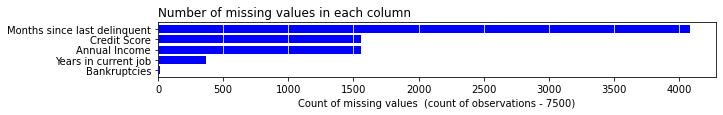

In [14]:
df_explore_missing(df_train)

### Обрабатываем пропуски

In [15]:
def years_job_tax(df):
    df.loc[df['Years in current job'] == '< 1 year', 'Years in current job'] = 0
    df.loc[df['Years in current job'] == '1 year', 'Years in current job'] = 1
    df.loc[df['Years in current job'] == '2 years', 'Years in current job'] = 2
    df.loc[df['Years in current job'] == '3 years', 'Years in current job'] = 3
    df.loc[df['Years in current job'] == '4 years', 'Years in current job'] = 4
    df.loc[df['Years in current job'] == '5 years', 'Years in current job'] = 5
    df.loc[df['Years in current job'] == '6 years', 'Years in current job'] = 6
    df.loc[df['Years in current job'] == '7 years', 'Years in current job'] = 7
    df.loc[df['Years in current job'] == '8 years', 'Years in current job'] = 8
    df.loc[df['Years in current job'] == '9 years', 'Years in current job'] = 9
    df.loc[df['Years in current job'] == '10+ years', 'Years in current job'] = 10
    df.loc[df['Years in current job'].isnull(), 'Years in current job'] = df['Years in current job'].median()
    df['Years in current job'] = df['Years in current job'].astype('int64')
    return df

In [16]:
def home_mort_rent_own(df):
    df.loc[df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
    return df

In [17]:
def a_income(df):
    df.loc[df['Annual Income'].isnull(), 'Annual Income'] = df['Annual Income'].median()
    return df

In [18]:
def months_del(df):
    df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = df['Months since last delinquent'].median()
    return df

In [19]:
def bankrupt(df):
    df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = df['Bankruptcies'].mode()
    df['Bankruptcies'] = df['Bankruptcies'].fillna(0.0)
    return df

In [20]:
def credit_score(df):
    df.loc[df['Credit Score'].isnull(), 'Credit Score'] = df['Credit Score'].median()
    df.loc[df['Credit Score'] > 750, 'Credit Score'] = df['Credit Score'].median()
    return df

In [21]:
def df_del_missing(df):
    df_dm = df.isnull().sum()
    df_dm = df_dm.drop(df_dm[df_dm == 0].index)
    df_dm = list(df_dm.index)
    df.drop(df_dm, axis=1, inplace=True)
    return df

### После анализа удаляем 'Purpose'

In [22]:
def num_purpose(df):
    df = df.drop('Purpose', axis=1)
    return df

## Построение новых признаков

In [23]:
def new_featurs(df):    
    for cat_colname in df.select_dtypes(include='object').columns:
        df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)
    return df

In [24]:
def pay_to_income(df):
    df['Pay To Income'] = df['Current Loan Amount'] / df['Annual Income']
    return df

In [25]:
def debt_to_income(df):
    debt_to_income = df.groupby(['Tax Liens', 'Annual Income'], as_index=False).\
    agg({'Maximum Open Credit': 'mean'}).rename(columns={'Maximum Open Credit': 'Debt To Income'})
    df = pd.merge(df, debt_to_income, on=[
                  'Tax Liens', 'Annual Income'], how='left')
    return df

In [26]:
def maximum_credit_score(df):
    df['Maximum_Credit_Score'] = df['Maximum Open Credit'] / df['Credit Score']
    return df

In [27]:
def maximum_credi_income(df):
    df['Maximum_Credi_Income'] = df['Maximum Open Credit'] / df['Current Loan Amount']
    return df

## Приступаем к созданию модели

### Создаем функцию обработки данных

In [28]:
def data_prepare(df):
    df = num_purpose(df)
    df = years_job_tax(df)
    df = home_mort_rent_own(df)
    df = a_income(df)
    df = months_del(df)
    df = bankrupt(df)
    df = credit_score(df)
    df = df_del_missing(df)
    df = new_featurs(df)
    df = pay_to_income(df)
    df = debt_to_income(df)
    df = maximum_credit_score(df)
    df = maximum_credi_income(df)
    return df

In [29]:
df = data_prepare(df_train)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 0 to 7499
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   int64  
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Term                          7500 non-null   object 
 11  Current Loan Amount           7500 non-null   float64
 12  Current Credit Balance        7500 non-null   float64
 13  Mon

In [31]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Credit Default,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Term_Long Term,Term_Short Term,Pay To Income,Debt To Income,Maximum_Credit_Score,Maximum_Credi_Income
0,Own Home,482087.0,6,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,...,0,0,1,0,0,1,207.431437,685960.0,915.834446,0.006860
1,Own Home,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,...,1,0,1,0,1,0,0.258383,810733.0,1603.432836,4.459897
2,Home Mortgage,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,...,0,1,0,0,0,1,133.082781,1182434.0,1593.576819,0.011824
3,Own Home,805068.0,6,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,...,0,0,1,0,0,1,0.150790,147400.0,212.391931,1.214208
4,Rent,776264.0,8,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,...,0,0,0,1,0,1,0.162110,385836.0,536.628651,3.066084


###  Приступаем к обработке данных

In [32]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME,'Purpose']).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

In [33]:
NUM_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Current Loan Amount', 'Current Credit Balance',
                     'Monthly Debt', 'Credit Score']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

In [34]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [35]:
sc = StandardScaler()

df_train = sc.fit_transform (X_train)
df_test = sc.transform (X_test)


In [36]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [37]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [38]:
model_lgbm = lgbm.LGBMClassifier(n_estimators=200, 
                                 max_depth=2, 
                                 num_leaves=4, 
                                 min_data_in_leaf=50,
                                 target='binary',
                                 lambda_l2=15,
                                 silent=True, 
                                 random_state=21
)

model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)
y_test_pred_probs = model_lgbm.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.81      0.77      3771
           1       0.73      0.63      0.67      2958

    accuracy                           0.73      6729
   macro avg       0.73      0.72      0.72      6729
weighted avg       0.73      0.73      0.73      6729

TEST

              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1616
           1       0.51      0.57      0.54       634

    accuracy                           0.72      2250
   macro avg       0.66      0.68      0.67      2250
weighted avg       0.73      0.72      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1263  353
1                273  361


### Иследуем важность признаков

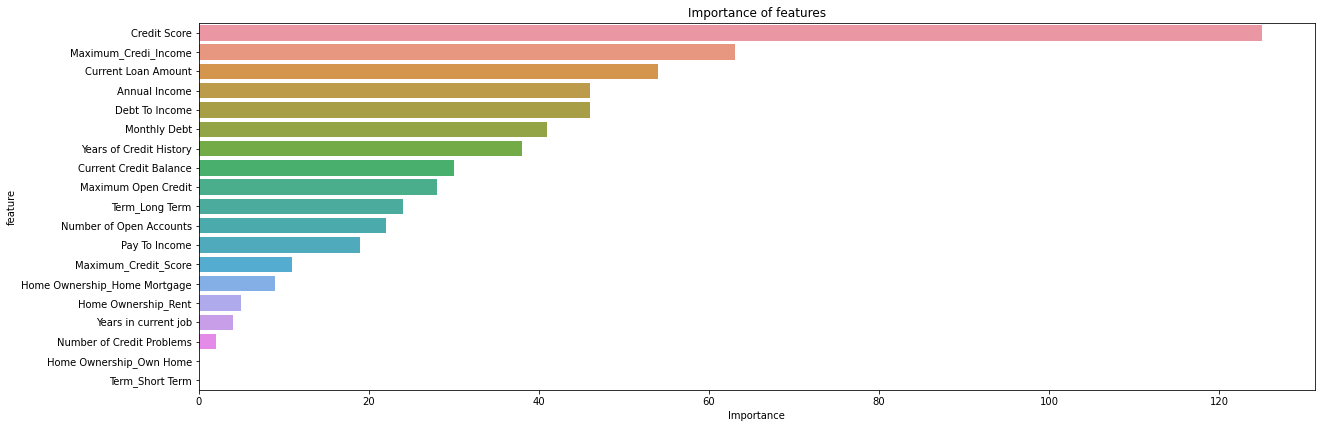

In [39]:
important_features_top = show_feature_importances(X_train.columns, model_lgbm.feature_importances_, get_top=25)

* "Плохих" признаков нет

### Подбор оптимального размера выборки, кривая обучения

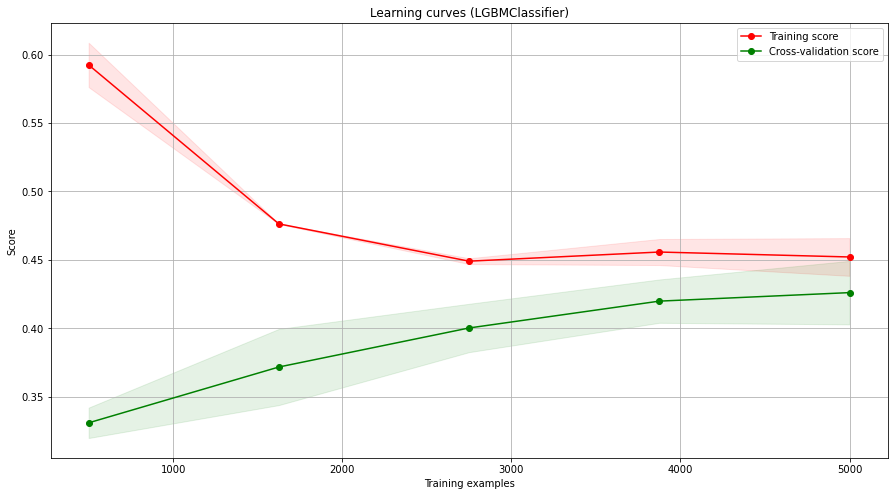

In [40]:
show_learning_curve_plot(model_lgbm, X, y)

* Улучшить ничего нельзя - кривые сходятся

### Выбор порога вероятности для определения класса

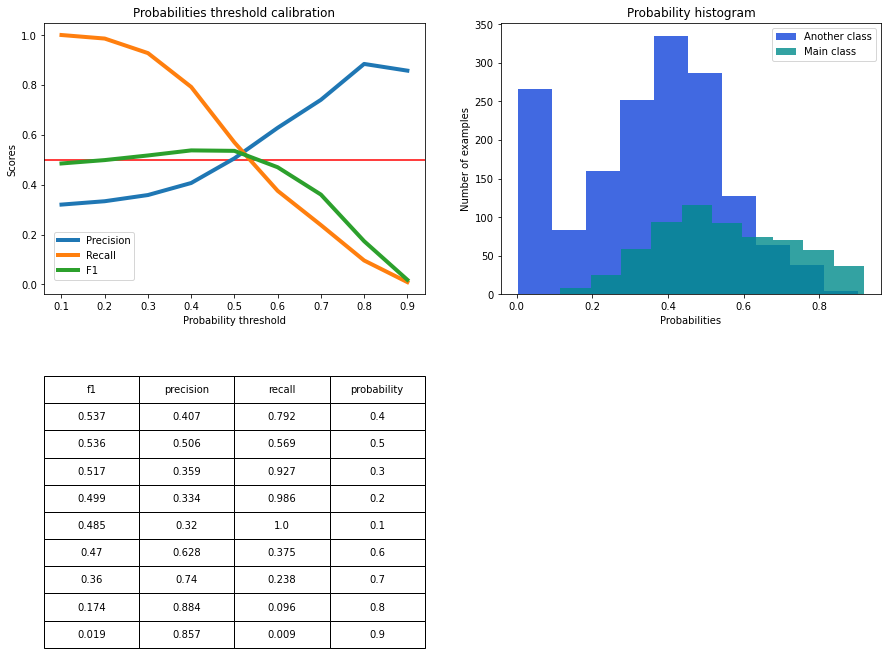

In [41]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

* Выбираем порог вероятности - 0.5

## Предсказание целевой переменной из тестового датасета

### Загружаем тестовый датасет

In [42]:
df_test = pd.read_csv(TEST_DATASET_PATH)

In [43]:
df_test = data_prepare(df_test)

df_test[SELECTED_FEATURE_NAMES].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 2499
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 2500 non-null   float64
 1   Years in current job          2500 non-null   int64  
 2   Number of Open Accounts       2500 non-null   float64
 3   Years of Credit History       2500 non-null   float64
 4   Maximum Open Credit           2500 non-null   float64
 5   Number of Credit Problems     2500 non-null   float64
 6   Current Loan Amount           2500 non-null   float64
 7   Current Credit Balance        2500 non-null   float64
 8   Monthly Debt                  2500 non-null   float64
 9   Credit Score                  2500 non-null   float64
 10  Home Ownership_Home Mortgage  2500 non-null   uint8  
 11  Home Ownership_Own Home       2500 non-null   uint8  
 12  Home Ownership_Rent           2500 non-null   uint8  
 13  Ter

In [44]:
df_test['Credit Default'] = model_lgbm.predict(df_test[SELECTED_FEATURE_NAMES])
df_test['Credit Default'] = np.where(
                                    df_test['Credit Default'] > 0.5, 1, 0
)

In [45]:
df_test['Credit Default'].to_csv('NSharovatov_predictions.csv', index=None)